In [1]:
import mne
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import scipy
import pywt

mne.set_log_level('WARNING')
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')

# Types
from typing import Annotated, Literal, TypeVar

DType = TypeVar("DType", bound=np.generic)
ArrayN = Annotated[npt.NDArray[DType], Literal['N']]

### Get Bonn University data
Sets A and B are from healthy patients, while Sets C, D, and E are from epileptic patients.

Sets C and D are seizure-free segments while set E is during a seizure.

Each set contains 100 single-channel EEG segments of 23.6-sec duration.

In [2]:
def get_data(channels: int, time_points: int) -> dict[str, np.ndarray]:
    data = dict()

    # maps from set_letter to set_letter_alternate (for the filenames)
    sets = {
        'A': 'Z',
        'B': 'O',
        'C': 'N',
        'D': 'F',
        'E': 'S'
    }

    for set_letter in sets:
        set_letter_alternate = sets[set_letter]

        set_data = np.zeros((channels, time_points))
        for i in range(channels):
            filename = f'data/bonn/SET {set_letter}/{set_letter_alternate}{str(i+1).zfill(3)}.txt'
            z = np.loadtxt(filename)
            set_data[i] = z[:time_points]

        data[set_letter] = set_data

    return data

channels, time_points = 100, 4096
freq = 173.61

set_letter = 'D'
data = get_data(channels, time_points)

info = mne.create_info(
    ch_names=[f'c{i}' for i in range(channels)],
    sfreq=freq,
    ch_types='eeg',
)
raw = mne.io.RawArray(data[set_letter], info)

# Preprocessing

### Filtering

In [3]:
# raw.copy().compute_psd().plot()

# raw.copy().plot(duration=5, n_channels=15, scalings=500)

raw = raw.notch_filter(freqs=50)
raw = raw.filter(l_freq=0.1, h_freq=50)

# raw.copy().compute_psd().plot();
# raw.copy().plot(duration=5, n_channels=15, scalings=500);


/var/folders/jn/90br8jjn68b1psqfzrd83ry40000gn/T/ipykernel_13305/4053739601.py:6: RuntimeWarning: filter_length (5731) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  raw = raw.filter(l_freq=0.1, h_freq=50)


### Segmentation into intervals

In [4]:
# TODO: see if the thing is actually split into time inveral??

total_seconds = time_points/freq
interval_length = 5  # in seconds

# create a list of numpy arrays, each containing the data of a single interval
intervals = []
t = 0
while t < time_points/freq:
    intervals.append(data[set_letter][:, int(t*freq):int((t+interval_length)*freq)])
    t += interval_length

# Feature Extraction

### Define 1D multilevel DWT function for each time interval (using Daubechies 4)

In [12]:
def discrete_wavelet_transform(interval_data):
    # 1D multilevel DWT
    cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(interval_data, wavelet='db4', level=4)
    # low frequencies => high time resolution, low freq resolution
    # high frequences => low time resolution, high freq resolution
    # print(cA4.shape)  # 0.1-4 Hz   60
    # print(cD4.shape)  # 4-8 Hz     60
    # print(cD3.shape)  # 8-15 Hz    114
    # print(cD2.shape)  # 15-30 Hz   222
    # print(cD1.shape)  # 30-60 Hz   437
    return cA4, cD4, cD3, cD2, cD1

### Define feature vector functions

In [6]:
def variance(data) -> ArrayN[np.float64]:
    variance_data = np.var(data, axis=1)
    return variance_data  # shape (# channels,)

def standard_deviation(data) -> ArrayN[np.float64]:
    std_data = np.std(data, axis=1)
    return std_data

def kurtosis(data) -> ArrayN[np.float64]:
    # fisher = True is default, which subtracts 3 from the final value
    return scipy.stats.kurtosis(data, axis=1, fisher=False)

def nn_shannon_entropy(data) -> ArrayN[np.float64]:
    # shannon entropy - a measure of how uncertain the data is (or how surprising it is?)
    # squared so log is never taken of a negative number in the data
    squared = data**2
    output = np.sum(squared * np.log(squared), axis=1)
    return output
    
    # output2 = np.sum(data * np.log(data), axis=1)
    # return output2   # returns nan because there are negative numbers
    return scipy.stats.entropy(data, axis=1)  # returns -inf

def logarithmic_band_power(data) -> ArrayN[np.float64]:
    n = data.shape[1]
    return np.log(np.sum(data**2, axis=1) / n)

def compute_features(data):
    return np.array([
        logarithmic_band_power(data),
        standard_deviation(data),
        variance(data),
        kurtosis(data),
        nn_shannon_entropy(data)
    ], dtype=np.float64).T

### Define feature vector graphing functions

In [17]:
BandType = Literal['A4', 'D4', 'D3', 'D2', 'D1']
FeatureType = Literal['LBP', 'Std', 'Var', 'Kur', 'SE']

def get_feature(
        feature_vector: np.ndarray,
        band: BandType,
        feature: FeatureType
    ) -> np.float64:
    
    bands = ['A4', 'D4', 'D3', 'D2', 'D1']
    features = ['LBP', 'Std', 'Var', 'Kur', 'SE']
    
    row = bands.index(band)
    col = features.index(feature)

    return feature_vector[row * len(features) + col]

def graph_feature_vectors(feature_vectors: np.ndarray, band_x: BandType, band_y: BandType, feature: FeatureType):
    points = []
    for feature_vector in feature_vectors:
        x = get_feature(feature_vector, band_x, feature)
        y = get_feature(feature_vector, band_y, feature)
        points.append((x, y))
    plt.scatter(*zip(*points))
    plt.show()

### Compute feature vector for each segment for each channel

(100, 25)
[9.55868172e+00 1.18076665e+02 1.39420988e+04 2.88925013e+00
 8.72129910e+06 6.91876628e+00 3.15738913e+01 9.96910614e+02
 4.48510842e+00 4.85333936e+05 6.20938629e+00 2.23019202e+01
 4.97375643e+02 9.20391374e+00 4.26051183e+05 3.85720425e+00
 6.87930862e+00 4.73248870e+01 3.53596273e+00 4.86662060e+04
 6.05226156e-01 1.35339069e+00 1.83166636e+00 3.48680612e+00
 1.14566045e+03]


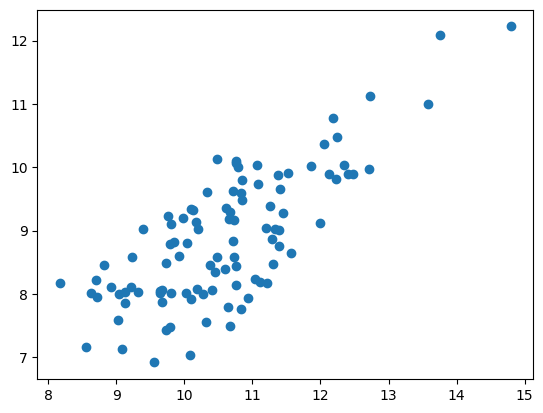

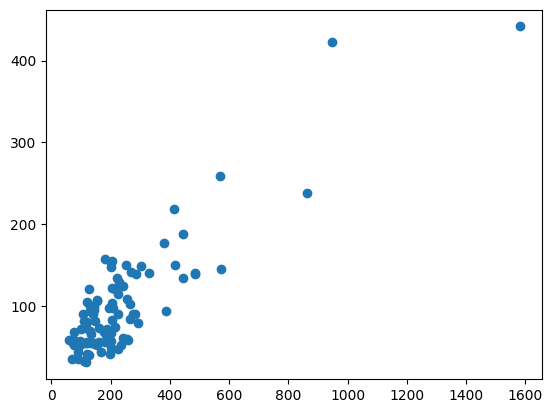

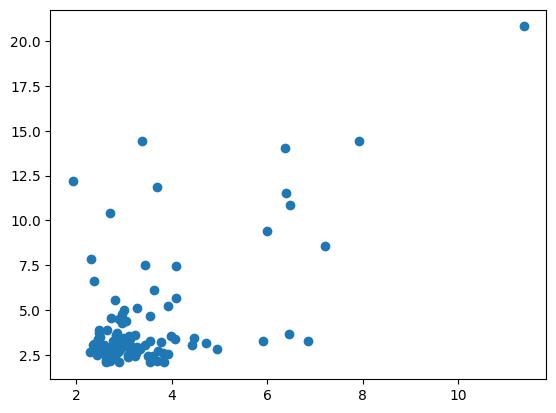

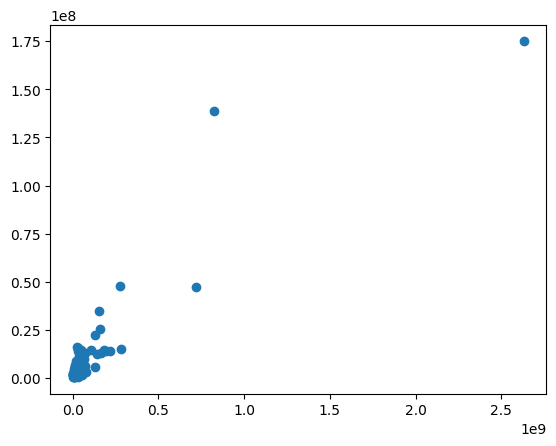

In [20]:
for i, interval_data in enumerate(intervals):
    # interval_data shape = (100, 868)
    if i > 0: break   # TODO debug: to test only 1 interval

    # Perform discrete wavelet transform on data
    dwt_outputs = discrete_wavelet_transform(interval_data=interval_data)

    # 5 features are extracted (LBP, SD, var, kur, SE) from each dwt output, so 5 rows, len(dwt_outputs) cols
    outputs = []
    for i, dwt_output in enumerate(dwt_outputs):
        # dwt_output shape could be any of (100, 60), (100, 114), (100, 222), (100, 437)
        # TODO: question: since there are 5 outputs from the DWT and 5 features, would there be 25 numbers in a feature vector? assuming yes
        # TODO: should the feature vectors be calculated separately for each channel? this would result in 100 * 25 features for each time segment. assuming yes

        # Compute features for each DWT output: [LBP, Std, Var, Kur, SE]
        features = compute_features(dwt_output)   # shape (# channels, 5 features)
        outputs.append(features)
    feature_vectors = np.hstack(outputs)
    # [LBP_A4, SD_A4, Var_A4, Kurt_A4, Ent_A4
    # LBP_D4, SD_D4, Var_D4, Kurt_D4, Ent_D4,
    # LBP_D3, SD_D3, Var_D3, Kurt_D3, Ent_D3,
    # LBP_D2, SD_D2, Var_D2, Kurt_D2, Ent_D2,
    # LBP_D1, SD_D1, Var_D1, Kurt_D1, Ent_D1] x 100 for all channels

    # delta = 0.1-4 Hz = A4
    # theta = 4-8 Hz   = D4

    # TODO: plot feature vectors across 
    print(feature_vectors.shape)  # (100, 25) - represents all the feature vectors of a specific time interval
    print(feature_vectors[0])
    graph_feature_vectors(feature_vectors, band_x='A4', band_y='D4', feature='LBP')
    # graph_feature_vectors(feature_vectors, band_x='A4', band_y='D4', feature='Std')
    # graph_feature_vectors(feature_vectors, band_x='A4', band_y='D4', feature='Kur')
    # graph_feature_vectors(feature_vectors, band_x='A4', band_y='D4', feature='SE')  # seems off